# People with or without masks detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [4]:
from tensorflow.keras.preprocessing.image import load_img

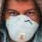

In [5]:
path = '../data/data/Train/WithMask/'
name = '4.png'
fullname = f'{path}/{name}'
fullname
load_img(fullname)

In [6]:
img = load_img(fullname, target_size=(299,299))

In [7]:
x = np.array(img)
x.shape

(299, 299, 3)

In [8]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [9]:
model = Xception(weights= 'imagenet', input_shape=(299,299,3))

In [10]:
X = np.array([x])

In [11]:
X.shape

(1, 299, 299, 3)

In [12]:
X = preprocess_input(X)

In [13]:
pred = model.predict(X)

1/1 [==============================] - 1s 1s/step


In [14]:
decode_predictions(pred)

[[('n03424325', 'gasmask', 0.054372024),
  ('n04370456', 'sweatshirt', 0.0481796),
  ('n03814639', 'neck_brace', 0.03075833),
  ('n02667093', 'abaya', 0.026551317),
  ('n03045698', 'cloak', 0.024661474)]]

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
# preprocessing_function: funcion que se va a aplicar a cada imagen
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# batch_size: cuantas imagenes se van a procesar a la vez
train_ds = train_gen.flow_from_directory('../data/data/Train', target_size= (150,150), batch_size=32)

Found 10000 images belonging to 2 classes.


In [17]:
train_ds.class_indices

{'WithMask': 0, 'WithoutMask': 1}

In [18]:
X, y = next(train_ds)

In [19]:
y[:5]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [20]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory('../data/data/Validation', target_size= (150,150), batch_size=32, shuffle=False)

Found 800 images belonging to 2 classes.


## Model training

### Xception

In [21]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150,150,3))

base_model.trainable = False # no se van a actualizar los pesos de la red


inputs = keras.Input(shape=(150,150,3)) # 150x150, 3 canales

base = base_model(inputs, training=False) # no se va a entrenar

vectors= keras.layers.GlobalAveragePooling2D()(base) # promedio de los vectores

outputs = keras.layers.Dense(2)(vectors) # 2 clases 

model = keras.Model(inputs, outputs) # modelo final

In [22]:
preds = model.predict(X)

1/1 [==============================] - 2s 2s/step


In [23]:
preds.shape

(32, 2)

In [24]:
learning_rate=0.1 
optimazer = keras.optimizers.Adam(learning_rate=learning_rate) # optimizador

loss = keras.losses.BinaryCrossentropy(from_logits=True) # funcion de perdida

model.compile(optimizer= optimazer, loss=loss, metrics=['accuracy']) # configuracion del modelo

In [25]:
history = model.fit(train_ds, epochs=1, validation_data=val_ds) # entrenamiento



313/313 [==============================] - 300s 946ms/step - loss: 0.2059 - accuracy: 0.9901 - val_loss: 0.2855 - val_accuracy: 0.9987


### MobileNet

In [26]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

In [30]:
# preprocessing_function: funcion que se va a aplicar a cada imagen
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# batch_size: cuantas imagenes se van a procesar a la vez
train_ds = train_gen.flow_from_directory('../data/data/Train', target_size= (224,224), batch_size=32)

Found 10000 images belonging to 2 classes.


In [31]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory('../data/data/Validation', target_size= (224,224), batch_size=32, shuffle=False)

Found 800 images belonging to 2 classes.


In [33]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

base_model.trainable = False # no se van a actualizar los pesos de la red

inputs = keras.Input(shape=(224,224,3)) # 150x150, 3 canales

base = base_model(inputs, training=False) # no se va a entrenar

vectors= keras.layers.GlobalAveragePooling2D()(base) # promedio de los vectores

outputs = keras.layers.Dense(2)(vectors) # 2 clases 

model = keras.Model(inputs, outputs) # modelo final

In [34]:
learning_rate=0.1 
optimazer = keras.optimizers.Adam(learning_rate=learning_rate) # optimizador

loss = keras.losses.BinaryCrossentropy(from_logits=True) # funcion de perdida

model.compile(optimizer= optimazer, loss=loss, metrics=['accuracy']) # configuracion del modelo

In [35]:
history = model.fit(train_ds, epochs=1, validation_data=val_ds) # entrenamiento

313/313 [==============================] - 144s 454ms/step - loss: 0.1744 - accuracy: 0.9889 - val_loss: 0.0309 - val_accuracy: 0.9987


### Tuning the hyperparameters

#### Learning Rate

In [36]:
def make_model(learning_rate=0.01):

    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model.trainable = False

#############################################################

    inputs = keras.Input(shape=(224,224,3))
    base = base_model(inputs, training=False)
    vectors= keras.layers.GlobalAveragePooling2D()(base) 
    outputs = keras.layers.Dense(2)(vectors)
    model = keras.Model(inputs, outputs)

#############################################################

    optimazer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(optimizer= optimazer, loss=loss, metrics=['accuracy'])

    return model

In [37]:
scores = {}

for lr in [0.0001, 0.001,0.01,0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=1, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.0001
313/313 [==============================] - 155s 491ms/step - loss: 0.2802 - accuracy: 0.9390 - val_loss: 0.1180 - val_accuracy: 0.9925


0.001
313/313 [==============================] - 170s 527ms/step - loss: 0.0632 - accuracy: 0.9858 - val_loss: 0.0201 - val_accuracy: 0.9962


0.01
313/313 [==============================] - 152s 478ms/step - loss: 0.0227 - accuracy: 0.9929 - val_loss: 0.0085 - val_accuracy: 0.9975


0.1
313/313 [==============================] - 146s 459ms/step - loss: 0.1638 - accuracy: 0.9901 - val_loss: 0.3032 - val_accuracy: 0.9862




the best LR -> learning_rate = 0.01

#### Dense layer

In [40]:
def make_model(learning_rate=0.01, size_inner= 100):

    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model.trainable = False

#############################################################

    inputs = keras.Input(shape=(224,224,3))
    base = base_model(inputs, training=False)
    vectors= keras.layers.GlobalAveragePooling2D()(base) 

    # 100 neuronas en la capa oculta 
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors) # capa oculta agregada lo que hace es que se agregan mas neuronas a la red para poder tener mas parametros y poder ajustar mejor los datos


    outputs = keras.layers.Dense(2)(inner)
    model = keras.Model(inputs, outputs)

#############################################################

    optimazer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(optimizer= optimazer, loss=loss, metrics=['accuracy'])

    return model

In [41]:
learning_rate = 0.01

scores = {}

for size in [10, 100, 1000]:
    print(size)
    
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=1, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
313/313 [==============================] - 134s 421ms/step - loss: 0.0304 - accuracy: 0.9917 - val_loss: 0.0171 - val_accuracy: 0.9975


100
313/313 [==============================] - 140s 440ms/step - loss: 0.0622 - accuracy: 0.9914 - val_loss: 0.0916 - val_accuracy: 0.9787


1000
313/313 [==============================] - 145s 457ms/step - loss: 0.1428 - accuracy: 0.9904 - val_loss: 0.0121 - val_accuracy: 0.9987




the best Dense layer -> DenseLayer = 10

#### Regularization and Dropout layer

In [42]:
def make_model(learning_rate=0.01, size_inner= 10, droprate=0.5):

    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model.trainable = False

#############################################################

    inputs = keras.Input(shape=(224,224,3))
    base = base_model(inputs, training=False)
    vectors= keras.layers.GlobalAveragePooling2D()(base) 

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors) # capa oculta agregada lo que hace es que se agregan mas neuronas a la red para poder tener mas parametros y poder ajustar mejor los datos
    drop = keras.layers.Dropout(droprate)(inner) # dropout es una capa que se agrega para evitar el overfitting lo que hace es que apaga algunas neuronas de manera aleatoria

    outputs = keras.layers.Dense(2)(drop)
    model = keras.Model(inputs, outputs)

#############################################################

    optimazer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(optimizer= optimazer, loss=loss, metrics=['accuracy'])

    return model

In [43]:
learning_rate = 0.001
size = 10

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    
    model = make_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)
    history = model.fit(train_ds, epochs=1, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

0.0
313/313 [==============================] - 132s 414ms/step - loss: 0.0338 - accuracy: 0.9898 - val_loss: 0.0114 - val_accuracy: 0.9987


0.2
313/313 [==============================] - 143s 448ms/step - loss: 0.1972 - accuracy: 0.9678 - val_loss: 0.0210 - val_accuracy: 0.9962


0.5
313/313 [==============================] - 147s 466ms/step - loss: 0.2887 - accuracy: 0.8563 - val_loss: 0.0264 - val_accuracy: 0.9975


0.8
313/313 [==============================] - 140s 439ms/step - loss: 0.5108 - accuracy: 0.7170 - val_loss: 0.0967 - val_accuracy: 0.9912




the best droprate -> droprate = 0.0

### Final model

In [49]:
def make_model(learning_rate=0.01, size_inner= 10, input_size=224):

    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model.trainable = False

#############################################################

    inputs = keras.Input(shape=(input_size,input_size,3))
    base = base_model(inputs, training=False)
    vectors= keras.layers.GlobalAveragePooling2D()(base) 

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors) # capa oculta agregada lo que hace es que se agregan mas neuronas a la red para poder tener mas parametros y poder ajustar mejor los datos

    outputs = keras.layers.Dense(2)(inner)
    model = keras.Model(inputs, outputs)

#############################################################

    optimazer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(optimizer= optimazer, loss=loss, metrics=['accuracy'])

    return model

In [46]:
input_size = 224

In [47]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    '../data/data/Train',
    target_size = (input_size,input_size),
    batch_size =16
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    '../data/data/Validation',
    target_size = (input_size,input_size),
    batch_size = 16,
    shuffle = False
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [48]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'mobileNet_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor = 'val_accuracy',
    mode='max'
)

In [50]:
learning_rate = 0.01
size = 10

model = make_model(
    input_size= 224,
    learning_rate=learning_rate,
    size_inner= size,
)

history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks= [checkpoint])

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9904

c:\Users\daniel\Documents\Universidad\Cursos\MLZoomCamp\Capstone_Project_2\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 140s 219ms/step - loss: 0.0334 - accuracy: 0.9904 - val_loss: 0.0115 - val_accuracy: 0.9950
Epoch 2/10
625/625 [==============================] - 148s 238ms/step - loss: 0.0084 - accuracy: 0.9973 - val_loss: 0.0076 - val_accuracy: 0.9987
Epoch 3/10
625/625 [==============================] - 150s 239ms/step - loss: 0.0039 - accuracy: 0.9986 - val_loss: 0.0100 - val_accuracy: 0.9962
Epoch 4/10
625/625 [==============================] - 147s 235ms/step - loss: 0.0045 - accuracy: 0.9984 - val_loss: 0.0581 - val_accuracy: 0.9900
Epoch 5/10
625/625 [==============================] - 143s 228ms/step - loss: 0.0046 - accuracy: 0.9982 - val_loss: 0.0462 - val_accuracy: 0.9862
Epoch 6/10
625/625 [==============================] - 142s 227ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.0116 - val_accuracy: 0.9987
Epoch 7/10
625/625 [==============================] - 146s 234ms/step - loss: 9.2797e-04 - accuracy: 0.9997 - val_loss: 0.0097 - val_ac